# Multi Race model
> May 2024

In [1]:
#| default_exp multi_race

In [2]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.models import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import copy
import typing
import warnings

import chaospy
import fastcore.test
import ipywidgets
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import scipy
import seaborn as sns
import tqdm

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


In [3]:
#| export payoffs

def build_payoffs_multi_race_v1(models):
   names1 = ["B_1", "B_2", "s_1", "s_2", "p_1", "p_2", "p_both"]
   names2 = [ "W_1", "W_2", "gamma_1", "gamma_2", "delta_1", "delta_2", "alpha_1", "alpha_2"]
   B_1, B_2, s_1, s_2, p_1, p_2, p_both = [models[k] for k in names1]
   W_1, W_2, gamma_1, gamma_2, delta_1, delta_2, alpha_1, alpha_2  = [models[k] for k in names2]
   profile = models["profile"]
   payoffs = models["payoffs"]
   strategy_profile = profile.split("-")

   market_share = lambda t_1, t_2, gamma : 0.5*gamma**(t_1 - t_2) if t_2 <= t_1 else 1 - 0.5*gamma**(t_2 - t_1)
   market_value = lambda b, delta, t : b * delta**t / (1 - delta) if delta < 1 else b

   # mapping_strategy_to_isolated_research_time
   # safe, unsafe, safe_phase_1, safe_phase_2
   mapping_s_to_irt = [W_1, W_1/s_1, W_1, W_1/s_1,
                       W_2, W_2/s_2, W_2, W_2/s_2]
   mapping_s_to_phase1_speed = [1, s_1, 1, s_1,
                                1, s_2, 1, s_2]
   mapping_s_to_phase2_speed = [alpha_1, alpha_1 * s_1, alpha_1 * s_1, alpha_1,
                                alpha_2, alpha_2 * s_2, alpha_2 * s_2, alpha_2]
   research_distance = [W_1, W_2]
   safe_research_boost = [alpha_1, alpha_2]
   leader = np.argmin(mapping_s_to_irt[a] for a in strategy_profile)
   layer_membership = [0, 0, 1, 1]
   leader_layer = layer_membership[leader]
   late_layer = 1 * (leader != 0)
   arrival_time_leader = np.minimum(mapping_s_to_irt[a] for a in strategy_profile)
   arrival_times = []
   layers_safe = [True, True]
   unsafe_players = []
   for i, a in enumerate(strategy_profile):
      if leader_layer == layer_membership[i]:
         arrival_time = mapping_s_to_irt[a]
         safe_time = research_distance[leader_layer]
      else:
         assert research_distance[late_layer] > arrival_time_leader * phase_1_speed
         phase_1_speed = mapping_s_to_phase1_speed[a]
         phase_2_speed = mapping_s_to_phase2_speed[a]
         arrival_time = (arrival_time_leader 
                         + ((research_distance[late_layer]
                             - arrival_time_leader * phase_1_speed)
                            /phase_2_speed))
         safe_time = (arrival_time_leader 
                         + ((research_distance[late_layer]
                             - arrival_time_leader)
                            /safe_research_boost[late_layer]))
      arrival_times.append(arrival_time)
      # If one player is unsafe in the layer, then the layer is unsafe.
      if safe_time > arrival_time:
         layers_safe[layer_membership[i]] =  False
      unsafe_players.append(safe_time > arrival_time)
   
   # Who wins in each layer?
   layer_1_times = [arrival_time for i, arrival_time in enumerate(arrival_times)
                    if layer_membership[i] == 0]
   layer_2_times = [arrival_time for i, arrival_time in enumerate(arrival_times)
                     if layer_membership[i] == 1]

   # Given arrival times and safe times, as well as the equations for market
   # value, market share, and risk, we can now compute the payoffs.
   
   if layers_safe[0] == True and layers_safe[1] == True:
      risk_factor = 0
   elif layers_safe[0] == False and layers_safe[1] == False:
      risk_factor = 1 - p_both
   elif layers_safe[0] == True and layers_safe[1] == False:
      risk_factor = 1 - p_2
   elif layers_safe[0] == False and layers_safe[1] == True:
      risk_factor = 1 - p_1
   else:
      raise ValueError("This should not happen.")
   
   payoffs_p1 = (market_share(layer_1_times[0], layer_1_times[1], gamma_1)
                * market_value(B_1, delta_1, layer_1_times[0])
                * (risk_factor if unsafe_players[0] else 1))
   payoffs_p2 = (market_share(layer_1_times[1], layer_1_times[0], gamma_1)
                * market_value(B_1, delta_1, layer_1_times[1])
                * (risk_factor if unsafe_players[1] else 1))
   payoffs_p3 = (market_share(layer_2_times[0], layer_2_times[1], gamma_2)
                  * market_value(B_2, delta_2, layer_2_times[0])
                  * (risk_factor if unsafe_players[2] else 1))
   payoffs_p4 = (market_share(layer_2_times[1], layer_2_times[0], gamma_2)
                  * market_value(B_2, delta_2, layer_2_times[1])
                  * (risk_factor if unsafe_players[3] else 1))
   payoffs[profile] = {"P4": payoffs_p4,
                         "P3": payoffs_p3,
                         "P2": payoffs_p2,
                         "P1": payoffs_p1}
   return {**models, "payoffs": payoffs}

@method(build_payoffs, "multi-race-v1")
def build_payoffs(models):
   """Payoff matrix for the Multi Race game."""
   
   # Generate strings of the form "5-5-1-1" where the first two numbers
   # are chosen from 5 to 8 and the last two numbers are chosen from 1 to 4.
   profiles = [f"{a}-{b}-{c}-{d}" for a in range(5, 9)
                                   for b in range(5, 9)
                                   for c in range(1, 5)
                                   for d in range(1, 5)]
   models["payoffs"] = {}
   for profile in profiles:
      models["profile"] = profile
      # Builds the payoffs for the current profile.
      models = build_payoffs_multi_race_v1(models)

   return models

In [4]:
# Z = {"S3": 500, "S2": 50, "S1": 5}
# β = 1
sector_strategies = {"S2": [5, 6, 7, 8],
                     "S1": [1, 2, 3, 4],}
allowed_sectors = {"P4": ["S2"],
                   "P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_multi_race()
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "ai-trust-v1",
        #   "game_welfare_rule": "ai-trust-v1",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

In [8]:
# models = {**models,
#           **build_muulti_race(),
#           }
# models['β'] = {"S1": models['β'], "S2": models['β'],  "S3": models['β']}
# # Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s_1': (4372281,),
 'p_1': (4372281,),
 's_2': (4372281,),
 'p_2': (4372281,),
 'B_1': (4372281,),
 'B_2': (4372281,),
 'p_both': (4372281,),
 'W_1': (4372281,),
 'W_2': (4372281,),
 'gamma_1': (4372281,),
 'gamma_2': (4372281,),
 'delta_1': (4372281,),
 'delta_2': (4372281,),
 'alpha_1': (4372281,),
 'alpha_2': (4372281,)}

In [6]:
models.get("dispatch-type")

'multiple-populations'

In [7]:
results = thread_macro(models,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       )

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):


AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
df = thread_macro(results,
                  results_to_dataframe_egt,
                  )

In [ ]:
{k: results[k].shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'Eps': (800,),
 'b_fo': (800,),
 'bU': (800,),
 'bP': (800,),
 'cP': (800,),
 'u': (800,),
 'cR': (800,),
 'bR': (800,),
 'v': (800,),
 'transition_matrix': (800, 12, 12),
 'ergodic': (800, 12)}

In [ ]:
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

In [ ]:
df

,Eps,b_fo,bU,bP,cP,u,cR,bR,v,T-C-C_frequency,...,T-D-C_frequency,T-D-D_frequency,N-C-C_frequency,N-C-D_frequency,N-D-C_frequency,N-D-D_frequency,CT-C-C_frequency,CT-C-D_frequency,CT-D-C_frequency,CT-D-D_frequency
0,-1.0,0.0,4,4,0.5,1.5,5,4,0.5,1.604308e-09,...,4.988922e-10,0.000456,1.144023e-11,0.000456,3.624784e-08,0.496256,5.960471e-08,0.000456,4.279903e-08,0.496254
1,-1.0,0.5,4,4,0.5,1.5,5,4,0.5,1.148582e-07,...,5.397813e-08,0.000456,1.195687e-09,0.000456,3.788222e-06,0.496328,4.081118e-06,0.000457,4.471041e-06,0.496161
2,-1.0,1.0,4,4,0.5,1.5,5,4,0.5,9.027006e-06,...,4.408113e-06,0.000503,9.402336e-08,0.000463,2.978884e-04,0.501957,3.191659e-04,0.000527,3.514187e-04,0.488845
3,-1.0,1.5,4,4,0.5,1.5,5,4,0.5,1.953782e-04,...,9.900395e-05,0.001469,2.026193e-06,0.000607,6.419463e-03,0.619084,6.874017e-03,0.001999,7.569024e-03,0.336603
4,-1.0,2.0,4,4,0.5,1.5,5,4,0.5,4.299895e-04,...,2.268640e-04,0.002669,4.436927e-06,0.000788,1.405724e-02,0.765122,1.504369e-02,0.003834,1.656447e-02,0.146766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.9,17.5,4,4,0.5,1.5,5,4,0.5,6.361209e-02,...,2.664037e-01,0.039693,1.434967e-17,0.000197,1.454710e-17,0.000042,3.130188e-02,0.007667,2.790795e-02,0.000339
796,0.9,18.0,4,4,0.5,1.5,5,4,0.5,6.366254e-02,...,2.666140e-01,0.038906,1.307549e-17,0.000197,1.965339e-17,0.000042,3.133529e-02,0.007676,2.793957e-02,0.000337
797,0.9,18.5,4,4,0.5,1.5,5,4,0.5,6.370866e-02,...,2.668064e-01,0.038186,8.729897e-18,0.000198,3.954437e-17,0.000042,3.136603e-02,0.007683,2.796870e-02,0.000334
798,0.9,19.0,4,4,0.5,1.5,5,4,0.5,6.375094e-02,...,2.669827e-01,0.037526,1.968533e-17,0.000198,3.919734e-17,0.000042,3.139438e-02,0.007690,2.799558e-02,0.000332


In [ ]:
df["Eps"] = np.round(df["Eps"], 2)

In [ ]:
df["Eps"]

0     -1.0
1     -1.0
2     -1.0
3     -1.0
4     -1.0
      ... 
795    0.9
796    0.9
797    0.9
798    0.9
799    0.9
Name: Eps, Length: 800, dtype: float64

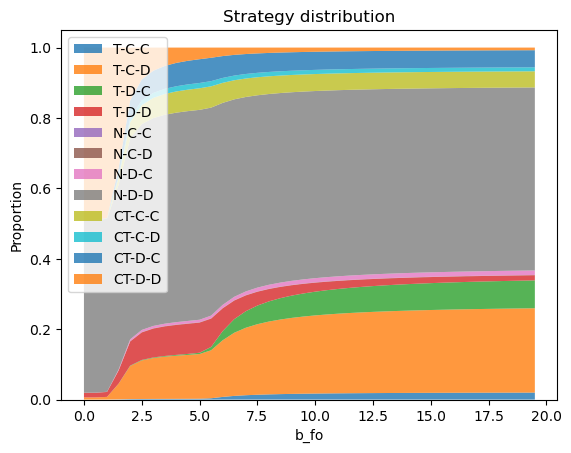

In [ ]:
plot_strategy_distribution(df[df["Eps"] == -0.1],
                           results['strategy_set'],
                           x="b_fo",
                           x_label="b_fo",
                           thresholds=None,
                           )

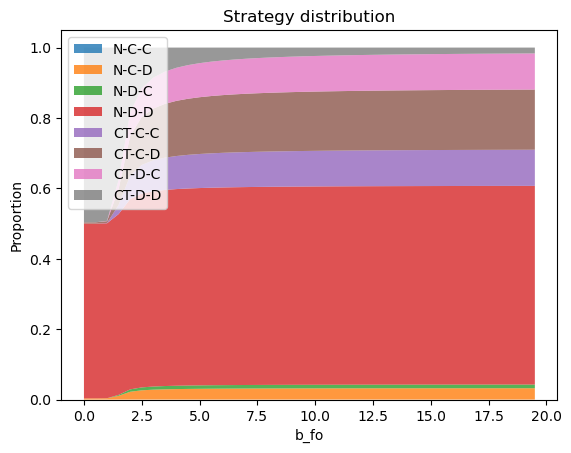

In [ ]:
plot_strategy_distribution(df[df["Eps"] == -0.1],
                           results['strategy_set'],
                           x="b_fo",
                           x_label="b_fo",
                           thresholds=None,
                           )

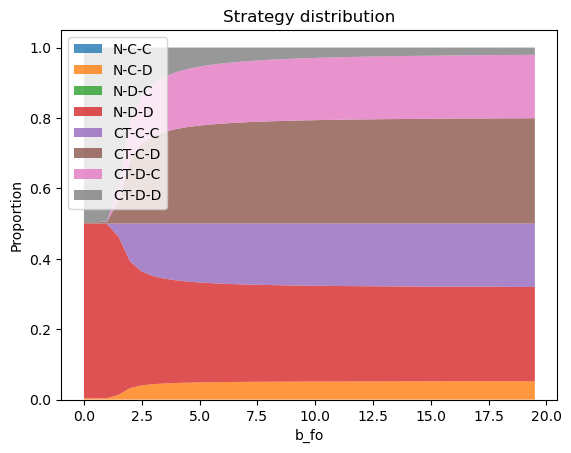

In [ ]:
plot_strategy_distribution(df[df["Eps"] == 0.2],
                           results['strategy_set'],
                           x="b_fo",
                           x_label="b_fo",
                           thresholds=None,
                           )

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Bounty for regulators, b_fo', ylabel='Externality impact, Eps'>,
 <matplotlib.image.AxesImage at 0x7a98775be320>)

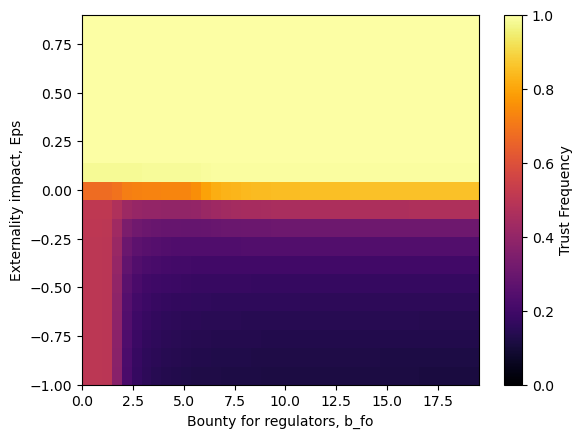

In [ ]:
# df['Trust_frequency'] = (df['T-D-D_frequency']
#                       + df['T-D-C_frequency']
#                       + df['T-C-D_frequency']
#                       + df['T-C-C_frequency'])
df['Trust_frequency'] = (df['CT-D-D_frequency']
                      + df['CT-D-C_frequency']
                      + df['CT-C-D_frequency']
                      + df['CT-C-C_frequency']
                      + df['T-D-D_frequency']
                      + df['T-D-C_frequency']
                      + df['T-C-D_frequency']
                      + df['T-C-C_frequency'])

table = df.pivot_table(index='Eps', columns='b_fo', values='Trust_frequency')
plot_heatmap(table,
             xlabel='Bounty for regulators, b_fo',
             ylabel='Externality impact, Eps',
             zlabel='Trust Frequency',
             cmap='inferno',
             )


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Bounty for regulators, b_fo', ylabel='Externality impact, Eps'>,
 <matplotlib.image.AxesImage at 0x7a9877736890>)

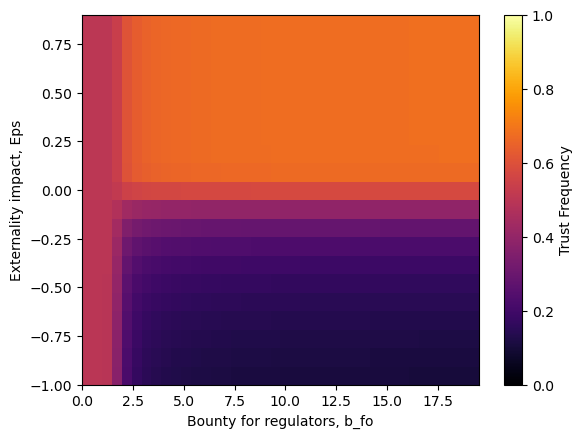

In [ ]:
# df['Trust_frequency'] = (df['T-D-D_frequency']
#                       + df['T-D-C_frequency']
#                       + df['T-C-D_frequency']
#                       + df['T-C-C_frequency'])
df['Trust_frequency'] = (df['CT-D-D_frequency']
                      + df['CT-D-C_frequency']
                      + df['CT-C-D_frequency']
                      + df['CT-C-C_frequency'])

table = df.pivot_table(index='Eps', columns='b_fo', values='Trust_frequency')
plot_heatmap(table,
             xlabel='Bounty for regulators, b_fo',
             ylabel='Externality impact, Eps',
             zlabel='Trust Frequency',
             cmap='inferno',
             )
